<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Автоэнкодер" data-toc-modified-id="Автоэнкодер-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Автоэнкодер</a></span></li><li><span><a href="#Вариационный-автоэнкодер" data-toc-modified-id="Вариационный-автоэнкодер-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Вариационный автоэнкодер</a></span></li></ul></div>

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

In [3]:
trainset = datasets.MNIST('.', download=True, train=True)
testset = datasets.MNIST('.', download=True, train=False)

train_dataloader = DataLoader(trainset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(testset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Автоэнкодер

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1),
                                     nn.MaxPool2d((2,2)),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 4, kernel_size=3, padding=1),
                                     nn.MaxPool2d((2,2)),
                                     nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Conv2d(4, 16, kernel_size=3, padding=1),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, kernel_size=3, padding=1),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 1, kernel_size=5, padding=2),
                                     nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
model = AutoEncoder()
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
num_epoches = 5
data_loaders = {'train' : train_dataloader, 'test' : test_dataloader}

In [7]:
for epoch in range(num_epoches):
  for k, loader in data_loaders.items():
    for batch in tqdm(loader):
      X_batch = batch['data'].to(device).unsqueeze(1)
      if k == 'train':
        model.train()
        optim.zero_grad()
        pred = model(X_batch)
        loss = loss_func(pred, X_batch)
        loss.backward()
        optim.step()
      else:
        model.eval()
        with torch.no_grad():
          pred = model(X_batch)
          loss = loss_func(pred, X_batch)
    print(f'Эпоха {epoch+1}, {k}: loss = {loss.item()}')


100%|██████████| 469/469 [06:24<00:00,  1.22it/s]


Эпоха 1, train: loss = 0.00774388900026679


100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


Эпоха 1, test: loss = 0.007467936724424362


100%|██████████| 469/469 [06:33<00:00,  1.19it/s]


Эпоха 2, train: loss = 0.006676446180790663


100%|██████████| 79/79 [00:10<00:00,  7.41it/s]


Эпоха 2, test: loss = 0.006138824857771397


100%|██████████| 469/469 [06:30<00:00,  1.20it/s]


Эпоха 3, train: loss = 0.00531868077814579


100%|██████████| 79/79 [00:10<00:00,  7.54it/s]


Эпоха 3, test: loss = 0.005363714415580034


100%|██████████| 469/469 [06:31<00:00,  1.20it/s]


Эпоха 4, train: loss = 0.0050795176066458225


100%|██████████| 79/79 [00:10<00:00,  7.60it/s]


Эпоха 4, test: loss = 0.004982004873454571


100%|██████████| 469/469 [06:31<00:00,  1.20it/s]


Эпоха 5, train: loss = 0.0045321788638830185


100%|██████████| 79/79 [00:10<00:00,  7.43it/s]

Эпоха 5, test: loss = 0.004738686140626669


In [8]:
test = testset.data[784].unsqueeze(0).unsqueeze(0).float() / 255
predict = model(test.to(device))

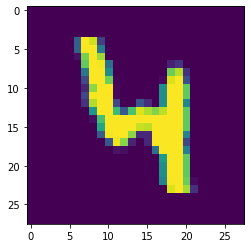

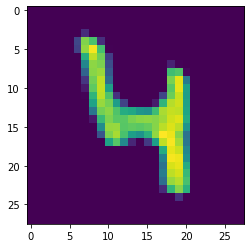

In [9]:
plt.imshow(test[0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].cpu().detach().numpy())
plt.show()

## Вариационный автоэнкодер

In [10]:
def sampling(mu, sigma):
    return mu + sigma * torch.normal(torch.zeros_like(mu), torch.ones_like(mu))

In [11]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))
    return torch.distributions.kl_divergence(p,q).mean()

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()     

        self.encoder = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                                     nn.MaxPool2d((2,2)),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 16, kernel_size=3, padding=1),
                                     nn.MaxPool2d((2,2)),
                                     nn.Conv2d(16, 1, kernel_size=3, padding=1))
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(1, 16, kernel_size=5, padding=2),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),
                                     nn.ReLU())
        
    def forward(self, x):
        activation = nn.ReLU()
        mu, sigma = activation(self.encoder(x)), torch.exp(self.encoder(x))
        x = self.decoder(sampling(mu, sigma))
        return x, mu, sigma

In [13]:
model = VAE()
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()

In [14]:
loaders = {"train": train_dataloader, "valid": test_dataloader}

In [15]:
for epoch in range(num_epoches):
  for k, loader in data_loaders.items():
    for batch in tqdm(loader):
      X_batch = batch['data'].to(device).unsqueeze(1)
      if k == 'train':
        model.train()
        optim.zero_grad()
        pred, mu, sigma = model(X_batch)
        loss = kl_loss(mu, sigma) + loss_func(pred, X_batch)
        loss.backward()
        optim.step()
      else:
        model.eval()
        with torch.no_grad():
          pred, mu, sigma = model(X_batch)
          loss = kl_loss(mu, sigma) + loss_func(pred, X_batch)
    print(f'Эпоха {epoch+1}, {k}: loss = {loss.item()}')

100%|██████████| 469/469 [02:38<00:00,  2.96it/s]


Эпоха 1, train: loss = 0.06888813525438309


100%|██████████| 79/79 [00:09<00:00,  8.66it/s]


Эпоха 1, test: loss = 0.07819855213165283


100%|██████████| 469/469 [02:30<00:00,  3.11it/s]


Эпоха 2, train: loss = 0.07166293263435364


100%|██████████| 79/79 [00:08<00:00,  8.79it/s]


Эпоха 2, test: loss = 0.07639928162097931


100%|██████████| 469/469 [02:32<00:00,  3.08it/s]


Эпоха 3, train: loss = 0.07028482854366302


100%|██████████| 79/79 [00:10<00:00,  7.25it/s]


Эпоха 3, test: loss = 0.07696264237165451


100%|██████████| 469/469 [03:08<00:00,  2.49it/s]


Эпоха 4, train: loss = 0.06834819912910461


100%|██████████| 79/79 [00:10<00:00,  7.27it/s]


Эпоха 4, test: loss = 0.07545821368694305


100%|██████████| 469/469 [03:03<00:00,  2.55it/s]


Эпоха 5, train: loss = 0.0710534080862999


100%|██████████| 79/79 [00:11<00:00,  7.16it/s]

Эпоха 5, test: loss = 0.07581210136413574


In [16]:
test = testset.data[784].unsqueeze(0).unsqueeze(0).float() / 255
predict, _, _ = model(test.to(device))

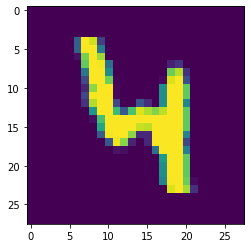

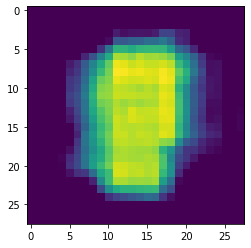

In [17]:
plt.imshow(test[0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].cpu().detach().numpy())
plt.show()